In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import math
import h5py
import os
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from typing import List, Optional, Union, Dict, Tuple
from scipy.sparse import dok_matrix, coo_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


                         **Tensorization of the CIC_IoT2024 Dataset**

This work focuses on the tensorization of the CIC_IoT2024 dataset, which was collected at the Canadian Institute for Cybersecurity (CIC). The dataset is specifically designed for two major tasks: IoT device identification and anomaly detection.

It consists of two sets of features:

Behavior-based features (such as HTTPS handshake information, User-Agent strings)

Flow-based features (including stream, channel, and jitter metrics over time intervals)

The dataset includes network traffic from 105 IoT devices and simulates 33 types of attacks, grouped into seven categories: DDoS, DoS, Reconnaissance, Web-based, Brute Force, Spoofing, and Mirai. All attacks are launched by malicious IoT devices targeting other IoT devices.

Tensorization allows for the transformation of this multi-source data into structured multi-dimensional arrays (tensors), capturing latent patterns and relationships across various dimensions (e.g., time, device, feature type). This approach supports more effective anomaly detection and classification in complex IoT environments.

We will construct two different tensors

1. Behavior based features tensor
2. Flow based tensor
The two tensors will be used for anomalies detection. For all class of features, we have taken one benign csv file and three anomalous for different attack in wich have taken a small proportion


**Let construct the Behavior based features tensor**


In [4]:
df_b = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Benign_packetbase/BenignTraffic.csv', on_bad_lines='skip', engine='python') #skip bad lines
df_D=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/anomalies_packetbased/DictionaryBruteForce.csv') #skip bad lines
df_DDoS=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/anomalies_packetbased/DDoS-TCP_Flood.csv') #skip bad lines
df_MITM=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/anomalies_packetbased/Mirai-greip_flood.csv') #skip bad lines

<ipython-input-4-41c32e769e66>:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_DDoS=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/anomalies_packetbased/DDoS-TCP_Flood.csv') #skip bad lines
<ipython-input-4-41c32e769e66>:4: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_MITM=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/anomalies_packetbased/Mirai-greip_flood.csv') #skip bad lines


In [ ]:
df_b['label']=0
df_D['label']=1
df_DDoS['label']=2
df_MITM['label']=3

In [ ]:
#we drop the na values in src_ip,dst_ip
df_b.dropna(subset=['src_ip','dst_ip'],inplace=True)
df_D.dropna(subset=['src_ip','dst_ip'],inplace=True)
df_DDoS.dropna(subset=['src_ip','dst_ip'],inplace=True)
df_MITM.dropna(subset=['src_ip','dst_ip'],inplace=True)

In [ ]:
#we drop the duplicated samples
df_b.drop_duplicates(inplace=True)
df_D.drop_duplicates(inplace=True)
df_DDoS.drop_duplicates(inplace=True)
df_MITM.drop_duplicates(inplace=True)

Each stream represents a different kind of communication between two IOT device, so we just consider the stream which are common

In [ ]:
stream_b = set(df_b['stream'].unique())
streams_D = set(df_D['stream'].unique())
streams_DDoS = set(df_DDoS['stream'].unique())
streams_MITM = set(df_MITM['stream'].unique())

In [ ]:
streams_communs = stream_b & streams_D & streams_DDoS & streams_MITM

In [ ]:
df_b= df_b[df_b['stream'].isin(streams_communs)]
df_D= df_D[df_D['stream'].isin(streams_communs)]
df_DDoS= df_DDoS[df_DDoS['stream'].isin(streams_communs)]
df_MITM= df_MITM[df_MITM['stream'].isin(streams_communs)]

In [ ]:
for i in [df_b,df_D,df_DDoS,df_MITM]:
    print(i.shape)

(74274, 136)
(49252, 136)
(1706, 136)
(7492, 136)


For resources reason, we just consider the most frequent streams in the benign trafic

In [ ]:
L=[]
for i in df_b['stream'].unique():
    if df_b['stream'].value_counts()[i]>300:
        L.append(i)
print(len(L))

40


In [ ]:
df_b_1= df_b[df_b['stream'].isin(L)]
df_D_1= df_D[df_D['stream'].isin(L)]
df_DDoS_1=df_DDoS[df_DDoS['stream'].isin(L)]
df_MITM_1=df_MITM[df_MITM['stream'].isin(L)]

In [ ]:
df_D_1.shape

(8375, 136)

For resources reasons, we just take a small proportion of each trafic

In [ ]:
df_b_2=df_b_1.sample(frac=0.2, random_state=42)
df_D_2=df_D_1.sample(frac=0.05, random_state=42)
df_MITM_2=df_MITM_1.sample(frac=0.1, random_state=42)

In [ ]:
df_DDoS_1.shape

(106, 136)

We concatenate all proportion in one dataFrame

In [ ]:
data=pd.concat([df_b_2,df_D_2,df_DDoS_1,df_MITM_2],axis=0)

In [ ]:
  data.shape

(10640, 136)

In [ ]:
data.describe()

,stream,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,l4_tcp,l4_udp,ttl,eth_size,...,sum_p,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count
count,5753.000000,5753.000000,5753.000000,5753.000000,5753.000000,5753.000000,5753.000000,5753.000000,5753.000000,5753.000000,...,5753.000000,5753.000000,5753.000000,5753.000000,5753.000000,5.753000e+03,5753.000000,5753.000000,5753.000000,5753.000000
mean,21.067269,31715.173649,22589.653572,8729.043521,0.019735,1.853989,0.514514,0.370937,114.515036,212.774379,...,3215.632192,13.716148,544.298105,135.255258,160.781610,1.276219e+05,217.131019,57.514601,159.616418,12.834347
std,27.008463,23913.440684,23574.131066,43323.612598,0.028974,0.929294,0.499833,0.483098,82.516188,426.662323,...,6458.356465,85.155317,1154.389214,336.572393,322.917823,7.803867e+05,479.733041,208.988081,404.615190,15.132580
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,43.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000
25%,1.000000,443.000000,443.000000,147.827263,0.002552,1.000000,0.000000,0.000000,64.000000,66.000000,...,905.000000,0.000000,121.000000,18.000000,45.250000,1.998661e+03,33.000000,6.000000,10.000000,3.000000
50%,15.000000,45855.000000,6667.000000,901.048882,0.009484,2.000000,1.000000,0.000000,64.000000,98.000000,...,1268.000000,6.000000,176.000000,33.000000,63.400000,3.892989e+03,102.000000,12.000000,59.250000,6.000000
75%,27.000000,51529.000000,49430.000000,1690.633075,0.025587,3.000000,1.000000,1.000000,231.000000,214.000000,...,2331.000000,12.000000,387.000000,110.000000,116.550000,1.276183e+04,172.000000,18.000000,112.750000,16.000000
max,193.000000,63703.000000,63703.000000,254638.940964,0.385394,3.000000,1.000000,1.000000,255.000000,5858.000000,...,59493.000000,1460.000000,30420.000000,2908.000000,2974.650000,4.244543e+07,4356.000000,2908.000000,3252.000000,93.000000


In [ ]:
#Data Description
data.head(20)

,stream,src_mac,dst_mac,src_ip,dst_ip,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,...,sum_p,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count
71819,10,dc:a6:32:dc:27:d5,Google Nest Mini Speaker,192.168.137.128,192.168.137.61,39024,8009,1110.767404,0.011138,2,...,1340.0,12.0,122.0,67.0,67.00,3.184211e+03,122.00,12.0,110.00,6.0
19760,75,3c:18:a0:41:c3:a0,Google Nest Mini Speaker,142.251.41.35,192.168.137.61,80,41800,142.623897,0.045359,2,...,1442.0,12.0,122.0,97.5,72.10,2.280095e+03,110.00,12.0,98.00,12.0
50329,120,3c:18:a0:41:c3:a0,Teckin Light Strip,100.20.212.253,192.168.137.31,8886,40454,703.302784,0.038994,2,...,876.0,0.0,110.0,36.0,43.80,1.243011e+03,69.00,15.0,54.00,42.0
2902,0,3c:18:a0:41:c3:a0,Arlo Q Indoor Camera,99.81.244.93,192.168.137.175,443,56891,18.323375,0.000965,3,...,23893.0,12.0,5804.0,1460.0,1194.65,2.145321e+06,1460.00,12.0,1448.00,3.0
117488,41,GoSund Smart Plug WP2 (2),ff:ff:ff:ff:ff:ff,192.168.137.151,255.255.255.255,49154,6667,1947.883597,0.023141,2,...,2331.0,0.0,188.0,188.0,116.55,8.276155e+03,188.00,0.0,188.00,3.0
108172,52,Rbcior Camera,ff:ff:ff:ff:ff:ff,192.168.137.76,255.255.255.255,50856,6667,1789.700931,0.030534,2,...,2115.0,0.0,188.0,132.5,105.75,7.079882e+03,188.00,12.0,176.00,17.0
122127,-1,Yi Indoor 2 Camera,3c:18:a0:41:c3:a0,192.168.137.249,192.168.137.1,0,0,2034.462087,0.028107,0,...,1016.0,0.0,134.0,48.0,50.80,2.678695e+03,92.25,0.0,92.25,10.0
69450,-1,Yi Indoor 2 Camera,3c:18:a0:41:c3:a0,192.168.137.249,8.8.8.8,0,0,1067.278519,0.000002,0,...,1126.0,0.0,164.0,24.0,56.30,4.320958e+03,134.00,0.0,134.00,10.0
139832,36,Atomi Coffee Maker,ff:ff:ff:ff:ff:ff,192.168.137.192,255.255.255.255,49231,6667,2358.733495,0.003871,2,...,2999.0,0.0,172.0,172.0,149.95,3.053945e+03,172.00,172.0,0.00,6.0
130669,27,Amazon Echo Dot 2,Amazon Echo Show,192.168.137.58,192.168.137.172,55444,55444,2192.984835,0.039712,3,...,697.0,18.0,210.0,18.0,34.85,2.747924e+03,18.00,18.0,0.00,5.0


In [ ]:
data.shape

(10640, 136)

We suggest to construct our tensor in many different ways

In [ ]:
subdata_1=data[['stream','src_ip','dst_ip','inter_arrival_time','sum_p']]
subdata_2=data[['stream','src_ip','dst_ip','sum_p','inter_arrival_time']]
subdata_3=data[['stream','src_ip','src_port','dst_port','dst_ip','inter_arrival_time']]
subdata_4=data[['stream','src_mac','dst_mac','inter_arrival_time','sum_p']]

We group 'inter_arrival_time' and 'sum_p' into class so that to reduce the number of unique values

In [ ]:
def group_by_threshold_with_ids(values, threshold):
    # Trier les valeurs uniques
    unique_values = np.sort(np.unique(values))

    # Initialiser les groupes
    groups = []
    current_group = [unique_values[0]]

    # Parcourir les valeurs uniques triées
    for i in range(1, len(unique_values)):
        # Si la différence avec la dernière valeur du groupe courant est inférieure au seuil
        if unique_values[i] - current_group[-1] <= threshold:
            current_group.append(unique_values[i])
        else:
            # Sinon, terminer le groupe actuel et en commencer un nouveau
            groups.append(current_group)
            current_group = [unique_values[i]]

    # Ajouter le dernier groupe
    if current_group:
        groups.append(current_group)

    # Créer un mapping des valeurs d'origine vers les identifiants de groupe (numéros)
    value_to_group_id = {}
    for group_id, group in enumerate(groups):
        for val in group:
            value_to_group_id[val] = group_id

    return value_to_group_id

# Appliquer le regroupement
threshold = 0.1  # Ajustez selon vos besoins et l'échelle de vos données
group_id_mapping = group_by_threshold_with_ids(data['inter_arrival_time'], threshold)

# Appliquer le mapping aux données
data['group_id'] = data['inter_arrival_time'].map(group_id_mapping)

# Vérification des résultats
print(f"Nombre de valeurs uniques avant groupage: {data['inter_arrival_time'].nunique()}")
print(f"Nombre de groupes après regroupement: {data['group_id'].nunique()}")

Nombre de valeurs uniques avant groupage: 10640
Nombre de groupes après regroupement: 5467


In [ ]:
group_id_mapping = group_by_threshold_with_ids(data['sum_p'], 10)
data['sum_p_id'] = data['sum_p'].map(group_id_mapping)

In [ ]:
data['sum_p_id'].nunique()

528

**First suggestion of the tensor**

In [ ]:
subdata_mac=data[['stream','src_mac','dst_mac','group_id','sum_p_id']]
subdata_ip=data[['stream','src_ip','dst_ip','group_id','sum_p_id']]

First proposition of the tensor

In [ ]:
from sklearn.preprocessing import LabelEncoder

def plot_3d_by_label(data, x_col, y_col, z_col, label_col):
    """
    Crée un graphique 3D avec trois dimensions, en encodant automatiquement les colonnes textuelles.
    Les points sont colorés selon le label (max 10 couleurs uniques).
    """

    df = data[[x_col, y_col, z_col, label_col]].copy()

    # Encoder les colonnes textuelles (par exemple src_ip, dst_ip, stream)
    for col in [x_col, y_col, z_col]:
        if df[col].dtype == 'object':
            df[col] = LabelEncoder().fit_transform(df[col])

    # Palette de couleurs pour les labels
    unique_labels = df[label_col].unique()
    palette = sns.color_palette("Set1", n_colors=len(unique_labels))

    # Création du graphique
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i, label in enumerate(unique_labels):
        subset = df[df[label_col] == label]
        ax.scatter(subset[x_col], subset[y_col], subset[z_col],
                   label=f'{label}', color=palette[i % len(palette)], alpha=0.7)

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_zlabel(z_col)
    ax.set_title(f'3D Plot of {x_col}, {y_col}, {z_col} colored by {label_col}')
    ax.legend()
    plt.tight_layout()
    plt.show()


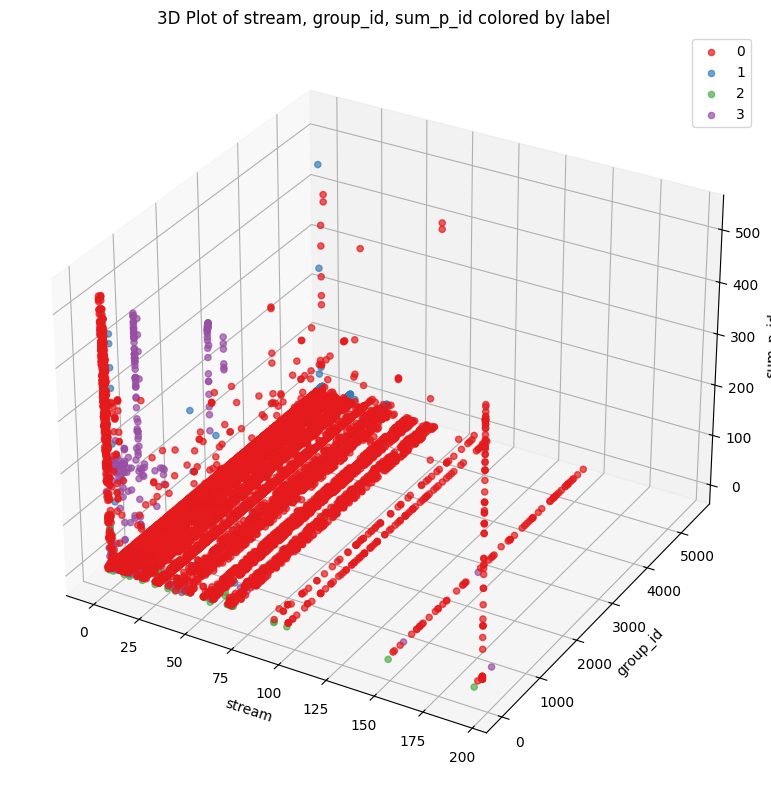

In [ ]:
 plot_3d_by_label(data, 'stream', 'group_id', 'sum_p_id','label')

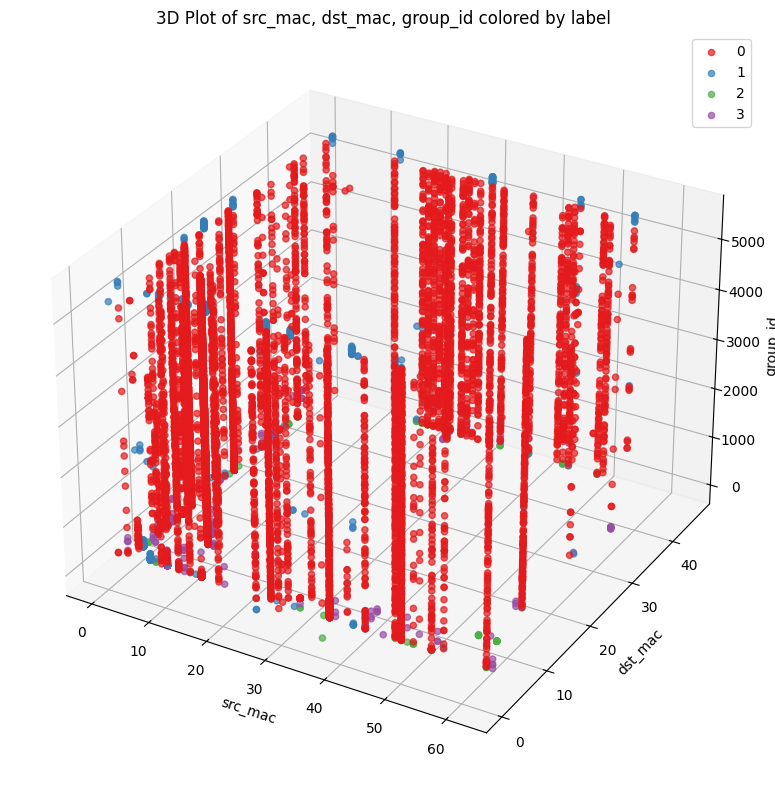

In [ ]:
plot_3d_by_label(data, 'src_mac', 'dst_mac', 'group_id','label')

In [ ]:
#Tensor construction
#For subdata_1 : We construct it in two ways : Dense and Sparse
def create_tensor(df):
    df_copy = df.copy()

    # 1. Création des mappings pour chaque colonne
    mappings = {}
    shape = []

    for col in df_copy.columns:
        uniques = sorted(df_copy[col].unique())
        mappings[col] = {val: idx for idx, val in enumerate(uniques)}
        shape.append(len(uniques))

    # 2. Initialisation du tenseur
    tensor = np.zeros(shape, dtype=np.int8)

    # 3. Remplissage du tenseur
    for _, row in df_copy.iterrows():
        try:
            idx = tuple(mappings[col][row[col]] for col in df_copy.columns)
            tensor[idx] = 1
        except KeyError:
            continue  # ignore si une valeur ne figure pas dans le mapping

    return tensor, mappings
tensor1, mappings1 = create_tensor(subdata_mac)
tensor2, mappings2 = create_tensor(subdata_ip)
# Afficher la forme du tenseur
print(f"Forme du tenseur 1 : {tensor1.shape}")
print(f"Forme du tenseur 2 : {tensor2.shape}")

Forme du tenseur 1 : (40, 63, 47, 5467, 528)
Forme du tenseur 2 : (40, 169, 138, 5467, 528)


In [ ]:
nzeros=np.count_nonzero(tensor1)

In [ ]:
nzeros

9406

In [ ]:
def convert_tensor_to_sparse(tensor):
    """
    Convertit un tenseur dense de grande dimension en format creux.

    Args:
        tensor: Tenseur dense numpy de dimension quelconque

    Returns:
        Un dictionnaire contenant:
        - indices: Les coordonnées des éléments non nuls
        - values: Les valeurs non nulles correspondantes
        - shape: La forme originale du tenseur
    """
    # Stocker la forme originale
    original_shape = tensor.shape

    # Obtenir les indices des éléments non nuls (sous forme de tuple de coordonnées)
    nonzero_indices = np.nonzero(tensor)

    # Obtenir les valeurs correspondantes aux indices non nuls
    nonzero_values = tensor[nonzero_indices]

    # Créer le dictionnaire de données creuses
    sparse_data = {
        'indices': np.array(nonzero_indices).T,  # Chaque ligne = une coordonnée complète
        'values': nonzero_values,
        'shape': original_shape
    }

    return sparse_data

def save_sparse_tensor(sparse_data, filename):
    """
    Sauvegarde un tenseur creux dans un fichier HDF5.

    Args:
        sparse_data: Le dictionnaire de données creuses
        filename: Le nom du fichier où sauvegarder
    """
    with h5py.File(filename, 'w') as f:
        f.create_dataset('indices', data=sparse_data['indices'])
        f.create_dataset('values', data=sparse_data['values'])
        f.create_dataset('shape', data=np.array(sparse_data['shape']))

def load_sparse_tensor(filename):
    """
    Charge un tenseur creux à partir d'un fichier HDF5.

    Args:
        filename: Le nom du fichier à charger

    Returns:
        Le dictionnaire de données creuses
    """
    sparse_data = {}
    with h5py.File(filename, 'r') as f:
        sparse_data['indices'] = f['indices'][()]
        sparse_data['values'] = f['values'][()]
        sparse_data['shape'] = f['shape'][()]

    return sparse_data

def reconstruct_tensor(sparse_data):
    """
    Reconstruit un tenseur dense à partir de sa représentation creuse.
    Attention: cette fonction peut consommer beaucoup de mémoire pour de très grands tenseurs.

    Args:
        sparse_data: Le dictionnaire de données creuses

    Returns:
        Le tenseur dense reconstruit
    """
    # Créer un tenseur vide
    result = np.zeros(sparse_data['shape'])

    # Convertir les indices en tuple pour l'indexation avancée
    idx = tuple(sparse_data['indices'].T)

    # Remplir avec les valeurs non nulles
    result[idx] = sparse_data['values']

    return result

def get_sparse_stats(sparse_data):
    """
    Calcule des statistiques sur le tenseur creux.

    Args:
        sparse_data: Le dictionnaire de données creuses

    Returns:
        Un dictionnaire de statistiques
    """
    total_elements = np.prod(sparse_data['shape'])
    nonzero_elements = len(sparse_data['values'])
    sparsity = 1.0 - (nonzero_elements / total_elements)

    stats = {
        'shape': sparse_data['shape'],
        'total_elements': total_elements,
        'nonzero_elements': nonzero_elements,
        'sparsity_ratio': sparsity,
        'memory_saved': 1 - ((nonzero_elements * 2) / total_elements)  # Approximation
    }

    return stats

def partial_tensor_operation(sparse_data, func):
    """
    Applique une fonction aux valeurs non nulles du tenseur sans le reconstruire.

    Args:
        sparse_data: Le dictionnaire de données creuses
        func: Une fonction à appliquer aux valeurs

    Returns:
        Un nouveau dictionnaire de données creuses avec les valeurs transformées
    """
    new_sparse_data = sparse_data.copy()
    new_sparse_data['values'] = func(sparse_data['values'])
    return new_sparse_data


# --------------------------
# # Pour un très grand tenseur
# tensor = np.random.random((80, 232, 207, 4031, 465))
# tensor[tensor < 0.9999] = 0  # La plupart des éléments sont nuls
#
# # Conversion au format creux
# sparse_data = convert_tensor_to_sparse(tensor)
#
# # Sauvegarde sur disque
# save_sparse_tensor(sparse_data, 'huge_sparse_tensor.h5')
#
# # Calcul des statistiques
# stats = get_sparse_stats(sparse_data)
# print(f"Taux de creux: {stats['sparsity_ratio']:.2%}")
# print(f"Mémoire économisée: {stats['memory_saved']:.2%}")
#
# # Application d'une opération sur les valeurs non nulles
# doubled_sparse = partial_tensor_operation(sparse_data, lambda x: x * 2)

In [ ]:
sparse_tensor=convert_tensor_to_sparse(tensor1)

In [ ]:
sparse_tensor

{'indices': array([[   0,    0,    4,  535,    7],
        [   0,    0,    4,  888,    7],
        [   0,    0,    4, 1382,    7],
        ...,
        [  39,   52,    4,   92,    7],
        [  39,   58,    9,   68,  215],
        [  39,   59,    9,    0,    2]]),
 'values': array([1, 1, 1, ..., 1, 1, 1], dtype=int8),
 'shape': (40, 63, 47, 5467, 528)}

**Construction of the Flow based tensor**

In [2]:
#Tensor construction for flowbased_features
df1=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Benign_flowbased/BenignTraffic.pcap_Flow.csv') #skip bad lines
df2=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Benign_flowbased/BenignTraffic.pcap_Flow.csv') #skip bad lines
df3=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Anomalies_fbased/DictionaryBruteForce.pcap_Flow.csv') #skip bad lines
df4=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Anomalies_fbased/DoS-UDP_Flood8.pcap_Flow.csv') #skip bad lines
df5=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets_iot/Anomalies_fbased/MITM-ArpSpoofing1.pcap_Flow.csv') #skip bad lines

In [4]:
df1.drop_duplicates(inplace=True)
df2.drop_duplicates(inplace=True)
df3.drop_duplicates(inplace=True)
df4.drop_duplicates(inplace=True)
df5.drop_duplicates(inplace=True)

In [5]:
df1['label']=0
df2['label']=0
df3['label']=1
df4['label']=2
df5['label']=3

In [6]:
df1['Timestamp']=pd.to_datetime(df1['Timestamp'])
df2['Timestamp']=pd.to_datetime(df2['Timestamp'])
df3['Timestamp']=pd.to_datetime(df3['Timestamp'])
df4['Timestamp']=pd.to_datetime(df4['Timestamp'])
df5['Timestamp']=pd.to_datetime(df5['Timestamp'])

<ipython-input-6-158d142f923d>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1['Timestamp']=pd.to_datetime(df1['Timestamp'])
<ipython-input-6-158d142f923d>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['Timestamp']=pd.to_datetime(df2['Timestamp'])
<ipython-input-6-158d142f923d>:3: UserWarning: Parsing dates in %d/%m/%Y %I:%M:%S %p format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df3['Timestamp']=pd.to_datetime(df3['Timestamp'])
<ipython-input-6-158d142f923d>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please s

In [7]:
df1.dropna(inplace=True)
df2.dropna(inplace=True)
df3.dropna(inplace=True)
df4.dropna(inplace=True)
df5.dropna(inplace=True)

In [11]:
data_flow=pd.concat([df1,df2,df3,df4,df5],axis=0)

In [42]:
data_flow.info()

<class 'pandas.core.frame.DataFrame'>
Index: 270750 entries, 0 to 9348
Data columns (total 85 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Flow ID                     270750 non-null  object        
 1   Src IP                      270750 non-null  object        
 2   Src Port                    270750 non-null  int64         
 3   Dst IP                      270750 non-null  object        
 4   Dst Port                    270750 non-null  int64         
 5   Protocol                    270750 non-null  int64         
 6   Timestamp                   270750 non-null  datetime64[ns]
 7   Flow Duration               270750 non-null  int64         
 8   Total Fwd Packet            270750 non-null  int64         
 9   Total Bwd packets           270750 non-null  int64         
 10  Total Length of Fwd Packet  270750 non-null  float64       
 11  Total Length of Bwd Packet  270750 non-null  f

In [49]:
data_flow.shape

(270750, 85)

In [48]:
data_flow.dropna(inplace=True)

In [50]:
data_flow.drop_duplicates(inplace=True)

In [51]:
data_flow.describe()

,Src Port,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
count,270750.000000,270750.000000,270750.000000,270750,2.707500e+05,270750.000000,270750.000000,2.707500e+05,2.707500e+05,270750.000000,...,270750.000000,2.707500e+05,2.707500e+05,2.707500e+05,2.707500e+05,2.707500e+05,2.707500e+05,2.707500e+05,2.707500e+05,270750.000000
mean,39168.466755,14509.914083,13.183343,2022-08-17 14:52:13.370134528,1.553049e+07,105.462482,7.198382,6.844322e+03,2.720746e+03,148.405378,...,15.315354,3.407298e+05,1.036882e+05,4.920248e+05,2.651037e+05,5.210590e+06,4.093771e+05,5.610456e+06,4.854399e+06,0.664787
min,0.000000,0.000000,0.000000,2022-07-10 14:15:00,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,34185.000000,53.000000,6.000000,2022-07-10 17:20:46,6.974500e+04,1.000000,0.000000,2.800000e+01,0.000000e+00,8.000000,...,8.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,43651.500000,443.000000,17.000000,2022-07-10 20:18:01,1.785455e+05,4.000000,1.000000,6.500000e+01,4.400000e+01,35.000000,...,8.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
75%,52371.000000,32100.000000,17.000000,2022-11-08 12:11:44,1.019203e+06,10.000000,4.000000,3.750000e+02,1.380000e+02,164.000000,...,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000
max,65533.000000,65531.000000,17.000000,2022-11-08 13:35:01,1.200000e+08,28654.000000,31711.000000,5.707314e+07,4.070550e+07,37648.000000,...,60.000000,1.132333e+08,6.054057e+07,1.132333e+08,1.132333e+08,1.199875e+08,6.986955e+07,1.199875e+08,1.199875e+08,3.000000
std,18051.456683,20159.165856,5.354107,NaN,3.553929e+07,325.353170,151.677806,2.021413e+05,2.359062e+05,743.827774,...,11.179181,2.058305e+06,7.789290e+05,2.705644e+06,1.842067e+06,1.547790e+07,3.272062e+06,1.634289e+07,1.512734e+07,0.988795


In [53]:
data_flow['Timestamp']=pd.to_datetime(data_flow['Timestamp'])

In [54]:
data_flow_2=data_flow[['Protocol','Flow ID',
'Timestamp',
'Flow Duration',
'Total Fwd Packet',
'Total Bwd packets','Flow Bytes/s',
'Flow Packets/s','FIN Flag Count',
'SYN Flag Count',
'RST Flag Count',
'PSH Flag Count',
'ACK Flag Count',
'URG Flag Count',
'CWR Flag Count',
'ECE Flag Count',
]]

In [60]:
def create_simple_dense_5d_tensor(df):

    # Extraire les dimensions uniques
    flow_ids = sorted(df['Flow ID'].unique())

    # Extraire les colonnes qui ne sont pas Flow_ID et Timestamp
    other_features = [col for col in df.columns if col not in ['Flow ID', 'Timestamp']]

    # Extraire les heures, minutes et secondes uniques
    hours = sorted(df['Timestamp'].dt.hour.unique())
    minutes = sorted(df['Timestamp'].dt.minute.unique())
    seconds = sorted(df['Timestamp'].dt.second.unique())

    # Créer des dictionnaires de mapping pour chaque dimension
    flow_id_to_idx = {flow_id: idx for idx, flow_id in enumerate(flow_ids)}
    feature_to_idx = {feature: idx for idx, feature in enumerate(other_features)}
    hour_to_idx = {hour: idx for idx, hour in enumerate(hours)}
    minute_to_idx = {minute: idx for idx, minute in enumerate(minutes)}
    second_to_idx = {second: idx for idx, second in enumerate(seconds)}

    # Dimensions du tenseur
    tensor_shape = (
        len(flow_ids),
        len(other_features),
        len(hours),
        len(minutes),
        len(seconds)
    )

    # Initialiser le tenseur avec des zéros
    tensor = np.zeros(tensor_shape, dtype=np.float32)

    # Remplir le tenseur
    for _, row in df.iterrows():
        flow_id = row['Flow ID']
        flow_idx = flow_id_to_idx[flow_id]
        hour_idx = hour_to_idx[row['Timestamp'].hour]
        minute_idx = minute_to_idx[row['Timestamp'].minute]
        second_idx = second_to_idx[row['Timestamp'].second]

        for feature in other_features:
            feature_idx = feature_to_idx[feature]
            tensor[flow_idx, feature_idx, hour_idx, minute_idx, second_idx] = row[feature]

    # Dictionnaire de mappings pour la traçabilité
    mappings = {
        'flow_id_to_idx': flow_id_to_idx,
        'feature_to_idx': feature_to_idx,
        'hour_to_idx': hour_to_idx,
        'minute_to_idx': minute_to_idx,
        'second_to_idx': second_to_idx,
        'idx_to_flow_id': {idx: flow_id for flow_id, idx in flow_id_to_idx.items()},
        'idx_to_feature': {idx: feature for feature, idx in feature_to_idx.items()},
        'idx_to_hour': {idx: hour for hour, idx in hour_to_idx.items()},
        'idx_to_minute': {idx: minute for minute, idx in minute_to_idx.items()},
        'idx_to_second': {idx: second for second, idx in second_to_idx.items()}
    }

    return tensor, mappings


# tensor, mappings = create_simple_dense_5d_tensor(df)

In [ ]:
tensor, mappings = create_simple_dense_5d_tensor(data_flow_2)

In [35]:
def create_sparse_5d_tensor(df, method='sparse_dok', output_file=None):

    # Extraire les dimensions uniques
    flow_ids = sorted(df['Flow ID'].unique())

    # Extraire les colonnes qui ne sont pas Flow_ID et Timestamp
    other_features = [col for col in df.columns if col not in ['Flow ID', 'Timestamp']]

    # Extraire les heures, minutes et secondes uniques
    hours = sorted(df['Timestamp'].dt.hour.unique())
    minutes = sorted(df['Timestamp'].dt.minute.unique())
    seconds = sorted(df['Timestamp'].dt.second.unique())

    # Créer des dictionnaires de mapping pour chaque dimension
    flow_id_to_idx = {flow_id: idx for idx, flow_id in enumerate(flow_ids)}
    feature_to_idx = {feature: idx for idx, feature in enumerate(other_features)}
    hour_to_idx = {hour: idx for idx, hour in enumerate(hours)}
    minute_to_idx = {minute: idx for idx, minute in enumerate(minutes)}
    second_to_idx = {second: idx for idx, second in enumerate(seconds)}

    # Dimensions d'une "slice" du tenseur (pour une Flow_ID)
    slice_shape = (
        len(other_features),
        len(hours),
        len(minutes),
        len(seconds)
    )

    # Dimensions complètes du tenseur
    full_shape = (
        len(flow_ids),
        len(other_features),
        len(hours),
        len(minutes),
        len(seconds)
    )

    # Dictionnaire de mappings pour la traçabilité
    mappings = {
        'flow_id_to_idx': flow_id_to_idx,
        'feature_to_idx': feature_to_idx,
        'hour_to_idx': hour_to_idx,
        'minute_to_idx': minute_to_idx,
        'second_to_idx': second_to_idx
    }

    if method == 'sparse_dok':
        # Création d'un dictionnaire de matrices creuses (une par Flow_ID)
        # Cette méthode ne conserve que les valeurs non-nulles
        sparse_tensors = {}

        # Regrouper par Flow_ID pour traiter séparément
        grouped = df.groupby('Flow ID')

        for flow_id, group in grouped:
            # Créer une matrice creuse DOK pour ce flow_id
            # On aplatit les 4 dernières dimensions en une seule
            flat_size = np.prod(slice_shape)
            sparse_matrix = dok_matrix((1, flat_size))

            for _, row in group.iterrows():
                hour_idx = hour_to_idx[row['Timestamp'].hour]
                minute_idx = minute_to_idx[row['Timestamp'].minute]
                second_idx = second_to_idx[row['Timestamp'].second]

                for feature in other_features:
                    feature_idx = feature_to_idx[feature]
                    value = row[feature]
                    if value != 0:  # Ne stocke que les valeurs non nulles
                        # Calculer l'index aplati
                        flat_idx = (feature_idx * len(hours) * len(minutes) * len(seconds) +
                                   hour_idx * len(minutes) * len(seconds) +
                                   minute_idx * len(seconds) +
                                   second_idx)
                        sparse_matrix[0, flat_idx] = value

            sparse_tensors[flow_id] = sparse_matrix

        return sparse_tensors, mappings

    elif method == 'sparse_coords':
        # Structure de données simple stockant uniquement les coordonnées et valeurs non-nulles
        coords = []
        data = []

        for _, row in df.iterrows():
            flow_id_idx = flow_id_to_idx[row['Flow ID']]
            hour_idx = hour_to_idx[row['Timestamp'].hour]
            minute_idx = minute_to_idx[row['Timestamp'].minute]
            second_idx = second_to_idx[row['Timestamp'].second]

            for feature in other_features:
                feature_idx = feature_to_idx[feature]
                value = row[feature]
                if value != 0:  # Ne stocke que les valeurs non nulles
                    coords.append([flow_id_idx, feature_idx, hour_idx, minute_idx, second_idx])
                    data.append(value)

        if coords:  # Vérifier si la liste n'est pas vide
            coords = np.array(coords)
            data = np.array(data)
            return (coords, data, full_shape), mappings
        else:
            return (np.zeros((0, 5)), np.array([]), full_shape), mappings

    elif method == 'hdf5':
        # Stockage sur disque avec HDF5
        if output_file is None:
            output_file = 'tensor_5d.h5'

        with h5py.File(output_file, 'w') as f:
            # Création du dataset avec compression
            dset = f.create_dataset('tensor',
                                   shape=full_shape,
                                   dtype='float32',
                                   compression='gzip',
                                   chunks=True)  # Chunking pour améliorer les performances d'accès

            # Remplissage par batches de Flow_ID
            for flow_id in flow_ids:
                flow_data = df[df['Flow ID'] == flow_id]
                flow_idx = flow_id_to_idx[flow_id]

                for _, row in flow_data.iterrows():
                    hour_idx = hour_to_idx[row['Timestamp'].hour]
                    minute_idx = minute_to_idx[row['Timestamp'].minute]
                    second_idx = second_to_idx[row['Timestamp'].second]

                    for feature in other_features:
                        feature_idx = feature_to_idx[feature]
                        dset[flow_idx, feature_idx, hour_idx, minute_idx, second_idx] = row[feature]

            # Stocker les mappings
            for map_name, mapping in mappings.items():
                grp = f.create_group(f'mappings/{map_name}')
                for key, value in mapping.items():
                    grp.attrs[str(key)] = value

        return output_file, mappings

    elif method == 'batch':
        # Traitement par lots (pour les très grands datasets)
        # Cette méthode ne charge qu'une portion des données à la fois
        def tensor_generator():
            for flow_id in flow_ids:
                flow_data = df[df['Flow ID'] == flow_id]
                flow_idx = flow_id_to_idx[flow_id]

                # Créer un tenseur creux pour ce flow_id spécifique
                # On utilise un dictionnaire Python standard pour économiser la mémoire
                sparse_dict = {}

                for _, row in flow_data.iterrows():
                    hour_idx = hour_to_idx[row['Timestamp'].hour]
                    minute_idx = minute_to_idx[row['Timestamp'].minute]
                    second_idx = second_to_idx[row['Timestamp'].second]

                    for feature in other_features:
                        feature_idx = feature_to_idx[feature]
                        value = row[feature]
                        if value != 0:  # Ne stocke que les valeurs non nulles
                            key = (feature_idx, hour_idx, minute_idx, second_idx)
                            sparse_dict[key] = value

                yield flow_id, sparse_dict, slice_shape

        return tensor_generator(), mappings

    else:
        raise ValueError(f"Méthode '{method}' non reconnue. Utilisez 'sparse_dok', 'sparse_coords', 'hdf5' ou 'batch'.")


# Pour une matrice creuse:
# sparse_tensors, mappings = create_sparse_5d_tensor(df, method='sparse_dok')

# Pour le stockage des coordonnées:
# (coords, data, shape), mappings = create_sparse_5d_tensor(df, method='sparse_coords')

# Pour le stockage HDF5:
# file_path, mappings = create_sparse_5d_tensor(df, method='hdf5', output_file='mon_tenseur.h5')

# Pour le traitement par lots:
# tensor_gen, mappings = create_sparse_5d_tensor(df, method='batch')
# for flow_id, sparse_dict, slice_shape in tensor_gen:
#     # Faire quelque chose avec chaque tranche du tenseur
#     process_tensor_slice(flow_id, sparse_dict, slice_shape)

In [36]:
(coords, data, shape), mappings = create_sparse_5d_tensor(data_flow_2, method='sparse_coords')

(201225, 14, 14, 60, 60)